In [1]:
require 'torch'
require 'image'
require 'nn'
require 'nngraph'
require 'cutorch'
require 'cunn'
require 'stn'

In [5]:
local scale = 0.50 -- 0.95 = 0.05% of augmentation ; 0.50 = 50%
local params
do
   local affineTransformGenerator =
      nn.AffineTransformMatrixGenerator(true, true, false)
   params = torch.Tensor(1,2)
   params[{1,1}] = 3.1415926*2
   params[{1,2}] = 1 -- translateX
--    params[{1,3}] = 0 -- translateY
   print('Params before affineTransformGenerator', params)
   params_affineTransform = affineTransformGenerator:forward(params)
   print('Affine Transform Matrix (3*2 params)', params_affineTransform)
end

Params before affineTransformGenerator	 6.2832  1.0000
[torch.DoubleTensor of size 1x2]

Affine Transform Matrix (3*2 params)	(1,.,.) = 
  1.0000  0.0000  0.0000
 -0.0000  1.0000  0.0000
[torch.DoubleTensor of size 1x2x3]



In [79]:
spanet = nn.Sequential()
local concat = nn.ConcatTable()
-- first branch is there to transpose inputs to BHWD, for the bilinear sampler
tranet = nn.Sequential()
tranet:add(nn.Identity())
tranet:add(nn.Transpose({2, 3}, {3, 4}))
-- second branch is the localization network
local locnet = nn.Sequential()
-- locnet:add(nn.Constant(1,1))
-- min, max, nInputDim, isangle=false, diff=false, verbose=false


sub = nn.Sequential()
u = nn.ConcatTable()
u:add(nn.Diffraction(-0, 0, 1, true, false, false))
u:add(nn.Diffraction(1/1.2, 1/1.2, 1, false, false, false))
sub:add(u)
sub:add(nn.JoinTable(1,1))
locnet:add(sub)
-- locnet:add(nn.Diffraction(-45, 45, 1, true, false, false))
locnet:add(nn.AffineTransformMatrixGenerator(true, true, false)) -- (useRotation, useScale, useTranslation)
locnet:add(nn.AffineGridGeneratorBHWD(512, 512))
-- we need a table input for the bilinear sampler, so we use concattable
concat:add(tranet)
concat:add(locnet)
spanet:add(concat)
spanet:add(nn.BilinearSamplerBHWD())
-- and we transpose back to standard BDHW format for subsequent processing by nn modules
spanet:add(nn.Transpose({3, 4}, {2, 3}))


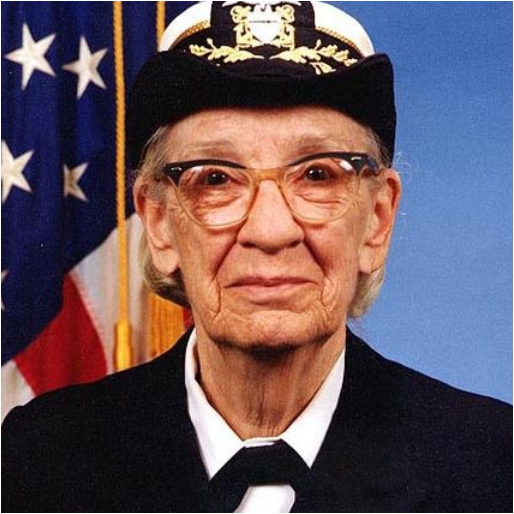

In [84]:
img = image.lena()
-- img = image.load("/home/coldmoon/Developer/caffe/examples/images/cat.jpg",3,'byte')
img = img:view(1,3,512,512)
im = spanet:forward(img)
itorch.image({im:view(3,512,512)})